# FundRaiser  
## Data Cleaning  

Overview: This notebook contains the code for Random Forest Regression algorithm to predict next cycle donation probability for each zipcode in the US.  

Donor probability is the number of donors in each zipcode, for each party as a proportion of the total number of possible donors in each zipcode, here the total population over the age of 18.

THL  
last updated July 22, 2019 (fixed comments only)

In [136]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [137]:
df = pd.read_csv("/Users/Taylor/Dropbox/0_Insight/PoliticalDonations/data/fullset_june30.csv",
                dtype={'zipcode': object, 'Pres_y1': object})


In [138]:
#df.dtypes

In [139]:
#df.isnull().sum()

In [140]:
df.sample(5)

,fecyear,zipcode,party,amt,ndon,amt_lastcycle,ndon_lastcycle,totalpopulation,median_age,totalpopulation_over18,...,a18450,a18500,a18300,a07260,a07220,a06500,cd,donor_prob,donor_prob_lastcycle,Pres_y1
111986,2010,54721,THR,0,0,0,0,1373,42.6,1057.0,...,0.000000,0.715336,1.749583,0.057399,0.268907,3.048849,3.0,0.0,0.0,0
155742,2012,15697,DEM,0,0,0,0,3038,42.9,2478.0,...,0.006434,0.234518,0.629707,0.005215,0.179761,3.162576,14.0,0.0,0.0,1
13541,2008,16731,REP,0,0,0,0,2956,37.9,2200.0,...,0.000000,0.185460,0.623145,0.000000,0.252226,2.974777,15.0,0.0,0.0,1
186066,2012,52753,THR,0,0,0,0,5153,41.9,3934.0,...,0.045333,1.780316,5.343406,0.011420,0.245080,11.714970,2.0,0.0,0.0,1
12530,2008,15427,THR,0,0,0,0,1162,42.5,941.0,...,0.000000,0.164835,0.421245,0.000000,0.201465,3.150183,14.0,0.0,0.0,1


In [141]:
df = pd.get_dummies(data=df, columns=['party'])
#df.head(5)

Create the test-train splits and a hold out for later model validation. 
Since there is inherent time component to these data I am not going to do this randomly. 

I am going to train on the 2008-2010 data, test on 2012 data, and keep the 2014 data as an additional holdout validation, and to use for the app. 

In [142]:
dfval = df[df.fecyear == 2014 ]
dftt = df[df.fecyear != 2014]

# for later outputs
valset_tokeep = df[df.fecyear == 2014 ]

In [143]:
dfval.shape
dftt.shape

(219968, 73)

Manually create the test-train splits by year rather than a random split to better capture the time component of these data.

In [144]:
df_0810  = df[df.fecyear < 2012 ]
df_12 = df[df.fecyear == 2012]
#df_12.describe()

Remove the target and a few other features that don't make sense, and/or where used to create the target (axis 1 is columns). 

I also removed the within fecyear amount and ndonors as I would not know those for the next cycle, and will only keep the one from previous cycle.  

n1 and n2 are basically the same thing as total population. 

Congressional district (cd) also does not make sense to include here. It likley matters at a broader scale but I don't have much data to inform that at this point so including it in the model does not make sense. I also envision this model being use for candidates running for smaller state and local offices as well so predicting agnostic of congressional district makes sense in that context as well.

In [145]:
# get the data in the correct format for a RF
labels = np.array(df_0810['donor_prob'])

df_0810 = df_0810.drop(['amt', 'ndon', 'donor_prob', 'donor_prob_lastcycle'
                  , 'totalpopulation_over18', 'zipcode', 'cd'
                  , 'n1', 'n2'], axis = 1)

# Saving feature names for later use
df_0810_list = list(df_0810.columns)

# Convert to numpy array
df_0810 = np.array(df_0810)

In [146]:
# get the data in the correct format for a RF
labels12 = np.array(df_12['donor_prob'])

df_12 = df_12.drop(['amt', 'ndon', 'donor_prob', 'donor_prob_lastcycle'
                  , 'totalpopulation_over18', 'zipcode', 'cd'
                  , 'n1', 'n2'], axis = 1)

# Saving feature names for later use
df_12_list = list(df_12.columns)

# Convert to numpy array
df_12 = np.array(df_12)

In [147]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 30, random_state = 8675309)

In [148]:
# Train the model on training data
rf.fit(df_0810, labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
           oob_score=False, random_state=8675309, verbose=0,
           warm_start=False)

In [149]:
predictions = rf.predict(df_12)

In [150]:
from sklearn import metrics
metrics.explained_variance_score(labels12, predictions)
# with only 10 trees  = 0.618
# with 20 trees = 0.71
# with 30 trees = 0.72

0.7191719747388702

In [151]:
metrics.mean_squared_error(labels12, predictions) 
# with 10 trees = 1.552e-05
# with 20 trees = 1.472e-05
# with 30 trees = 1.420e-05

1.4200467261493688e-05

In [152]:
metrics.median_absolute_error(labels12, predictions)
# with 10 trees  = 0.00022
# with 20 trees  = 0.00019
# with 30 trees  = 0.00020

0.0002090304510898082

In [153]:
metrics.mean_absolute_error(labels12, predictions)
# with 10 trees = 0.001019779
# with 20 trees = 0.000912970
# with 30 trees = 0.000912833

0.00091283390214391

In [154]:
metrics.r2_score(labels12, predictions)
# with 10 trees = 0.6180646658610581
# with 20 trees = 0.7088619950477972
# with 30 tress = 0.7191462616965787

0.7191462616965787

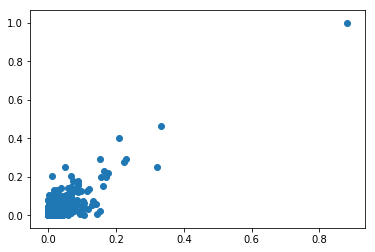

In [155]:
plt.scatter(predictions, labels12)

In [156]:
feature_imp = pd.Series(rf.feature_importances_, index=df_0810_list).sort_values(ascending=False)
feature_imp

amt_lastcycle                                   0.197839
ndon_lastcycle                                  0.122562
totalpopulation                                 0.058863
totalhouse_marriedwithkidsU18                   0.051922
totalpopulation_over65male                      0.046905
totalpopulation_over65female                    0.046836
totalpopulation_male                            0.043744
percent_black                                   0.034344
totalpopulation_over18female                    0.034090
totalpopulation_female                          0.027450
totalpopulation_over18male                      0.022194
totalpopulation_withrelativesinhouse            0.021782
fecyear                                         0.017884
Pres_y1                                         0.017366
totalhouse_livingalone_percent                  0.016544
a06500                                          0.015722
a07220                                          0.014329
totalpopulation_withrelativesin

### Validation on 2014 data

In [204]:
dfval.describe()

,fecyear,amt,ndon,amt_lastcycle,ndon_lastcycle,totalpopulation,median_age,totalpopulation_over18,totalpopulation_percentover18,totalpopulation_male,...,a18300,a07260,a07220,a06500,cd,donor_prob,donor_prob_lastcycle,party_DEM,party_REP,party_THR
count,77984.0,7.798400e+04,77984.000000,7.798400e+04,77984.000000,77984.000000,77984.000000,77984.000000,77984.000000,77984.000000,...,77984.000000,77984.000000,77984.000000,77984.000000,77984.000000,77984.000000,77984.000000,77984.000000,77984.000000,77984.000000
mean,2014.0,2.452014e+03,2.510246,6.130470e+03,8.099290,9606.912649,41.066929,7292.056627,76.817343,4725.366473,...,2.327937,0.005448,0.192726,6.492853,7.251321,0.000351,0.000800,0.334363,0.339518,0.326118
std,0.0,1.898273e+04,16.880124,5.554783e+04,62.931001,12803.316948,6.204015,9618.223983,4.834811,6257.825085,...,4.242597,0.009521,0.078652,9.563841,7.698958,0.004302,0.006757,0.471770,0.473549,0.468794
min,2014.0,0.000000e+00,0.000000,0.000000e+00,0.000000,4.000000,18.800000,4.000000,51.200000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.0,0.000000e+00,0.000000,0.000000e+00,0.000000,1247.000000,37.700000,963.000000,74.200000,628.000000,...,0.753051,0.000000,0.153516,3.301876,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.0,0.000000e+00,0.000000,0.000000e+00,0.000000,3677.000000,41.200000,2805.500000,76.700000,1847.000000,...,1.371882,0.003746,0.196426,4.530194,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2014.0,0.000000e+00,0.000000,0.000000e+00,0.000000,13325.000000,44.600000,10149.000000,79.300000,6567.000000,...,2.547278,0.007260,0.236772,6.594603,9.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,2014.0,1.224766e+06,954.000000,3.913820e+06,3974.000000,111086.000000,80.900000,77452.000000,100.000000,53241.000000,...,208.061900,0.277349,0.994883,542.554200,53.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [157]:
labels_val = np.array(dfval['donor_prob'])

dfval = dfval.drop(['amt', 'ndon', 'donor_prob', 'donor_prob_lastcycle'
                  , 'totalpopulation_over18', 'zipcode', 'cd'
                  , 'n1', 'n2'], axis = 1)

# Saving feature names for later use
dfval_list = list(dfval.columns)

# Convert to numpy array
dfval = np.array(dfval)

In [158]:
valpredictions = rf.predict(dfval)

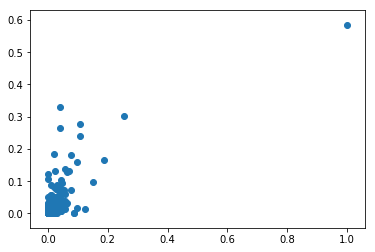

In [159]:
plt.scatter(labels_val, valpredictions)

In [160]:
metrics.r2_score(labels_val,valpredictions)

0.5201259385401789

In [240]:
df = pd.read_csv("/Users/Taylor/Dropbox/0_Insight/PoliticalDonations/data/fullset_june30.csv",
                dtype={'zipcode': object, 'Pres_y1': object})
df = pd.get_dummies(data=df, columns=['party'])
dfval = df[df.fecyear == 2014 ]

In [242]:
#valset_tokeep.dtypes

In [246]:
# write out the data I need to look at my business outcome.
tmp = pd.DataFrame({'zipcode': valset_tokeep.zipcode
              , 'partyDEM': dfval.party_DEM
              , 'partyREP': dfval.party_REP
              , 'partyTHR':dfval.party_THR
              , 'donor_prob':labels_val
              , 'donor_prob_predicted':valpredictions
              , 'donor_prob_lastcycle':valset_tokeep.donor_prob_lastcycle      
              , 'totalpopulation_over18':valset_tokeep.totalpopulation_over18})

In [247]:
tmp.to_csv(path_or_buf  = '/Users/Taylor/Dropbox/0_Insight/PoliticalDonations/data/predicted_probabilities_2014.csv', index=False)

The R2 for the validation data is 0.52. As expected, this is lower than the testing R2 and makes sense since 2014 donation probability is be predicted based on a model trained on 2008 and 2010 data.